In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

In [2]:
df = df.fillna(0)

In [3]:
# create another column for timestamp (to not mess up the one used as index) and remove timezone info
df["timestamp"] = df['time']
df['timestamp'] = df['timestamp'].astype(str)
df['timestamp'] = df['timestamp'].map(lambda x: str(x)[:-6])
df['datetime'] = pd.to_datetime(df['timestamp'])

# create year, month, day, weekday, date, is_holiday, season (by full months only: Dec, Jan, Feb as winter)

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour
df['date'] = df['datetime'].dt.date


# is_holiday
from datetime import date
import holidays
EE_holidays = holidays.EE()
df['is_holiday'] = [date in EE_holidays for date in df['date']]

# season
conditions = [
    (df['month'].isin(np.arange(3,6))), (df['month'].isin(np.arange(6,9))), 
    (df['month'].isin(np.arange(9,12))), (df['month'].isin(np.arange(1,3))), (df['month'] == 12)]
choices = ['Spring','Summer', 'Autumn', 'Winter', 'Winter']
df['season'] = np.select(conditions, choices)

# add google_trends info (weekly stats applied to all dates that week)
google_trends_weekly = [5,9,19,31,19,29,34,31,34,26,36,35,29,50,77,46,53,35,64,89,72,55,49,38,34,28,30,32,32,33,32,31,33,26,30,39,31,37,37,32,34,31,40,45,42,48,42,49,61,69,100,76]
google_trends_daily = np.repeat(google_trends_weekly,7)
index = [0,1,2]
google_trends_daily = np.delete(google_trends_daily, index)
google_trends_hourly = np.repeat(google_trends_daily,24)
df['google_trends_electricity'] = pd.Series(google_trends_hourly)


In [4]:
df.to_csv("df_clean.csv")

In [5]:
# first 30 days
df_30_d = df.head(720)
df_30_d


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,...,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,...,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,...,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,...,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,...,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,...,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2021-09-30 19:00:00+03:00,8.5,4.1,74.0,0.0,0.0,120.0,7.2,22.2,1029.7,...,2021-09-30 19:00:00,2021,9,30,3,19,2021-09-30,False,Autumn,19
716,2021-09-30 20:00:00+03:00,8.3,4.1,75.0,0.0,0.0,120.0,10.8,22.2,1029.9,...,2021-09-30 20:00:00,2021,9,30,3,20,2021-09-30,False,Autumn,19
717,2021-09-30 21:00:00+03:00,8.3,3.9,74.0,0.0,0.0,120.0,10.8,22.2,1030.0,...,2021-09-30 21:00:00,2021,9,30,3,21,2021-09-30,False,Autumn,19
718,2021-09-30 22:00:00+03:00,7.9,3.9,76.0,0.0,0.0,130.0,10.8,20.4,1030.0,...,2021-09-30 22:00:00,2021,9,30,3,22,2021-09-30,False,Autumn,19


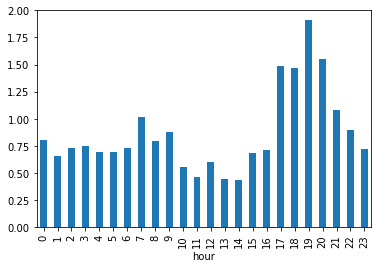

In [6]:
# first 30 days hourly consumption

data = df_30_d.groupby('hour').mean()['consumption']
data.plot(kind='bar',x='hour',y='consumption')

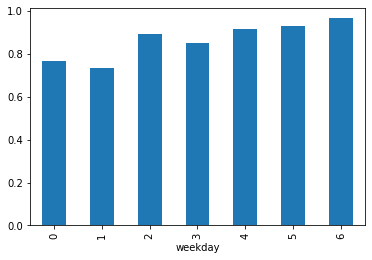

In [7]:
# first 30 days avg consumption by weekday 
data = df_30_d.groupby('weekday').mean()['consumption']
data.plot(kind='bar',x='weekday',y='consumption')

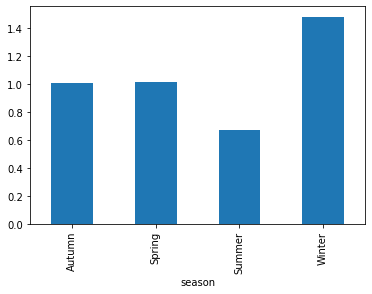

In [8]:
# seasonal avg consuption
data = df.groupby('season').mean()['consumption']
data.plot(kind='bar',x='season',y='consumption')

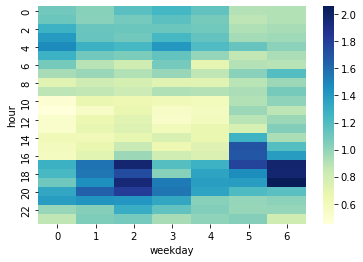

In [9]:
# consumption by weekday and hour
import seaborn as sns

heatmap1_data = pd.pivot_table(df, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap1_data, cmap="YlGnBu")

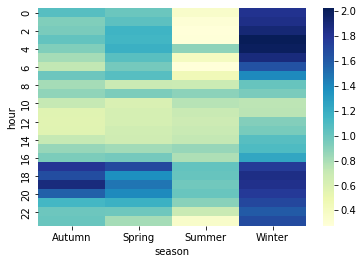

In [10]:
# consumption by hour and season

heatmap2_data = pd.pivot_table(df, values='consumption', 
                     index=['hour'], 
                     columns='season')

sns.heatmap(heatmap2_data, cmap="YlGnBu")

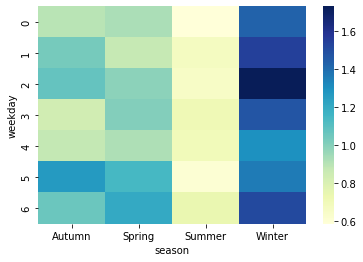

In [11]:
# consumption by weekday and season

heatmap2_data = pd.pivot_table(df, values='consumption', 
                     index=['weekday'], 
                     columns='season')

sns.heatmap(heatmap2_data, cmap="YlGnBu")

In [12]:
# separate df for seasons
spring = df[df['season'] == 'Spring']
summer = df[df['season'] == 'Summer']
autumn = df[df['season'] == 'Autumn']
winter = df[df['season'] == 'Winter']

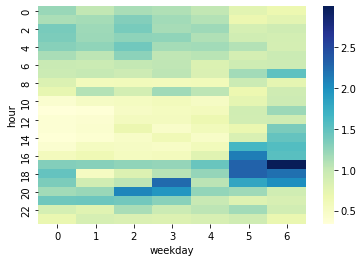

In [13]:
# consumption by hour and weekday in spring 
heatmap3_data = pd.pivot_table(spring, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap3_data, cmap="YlGnBu")

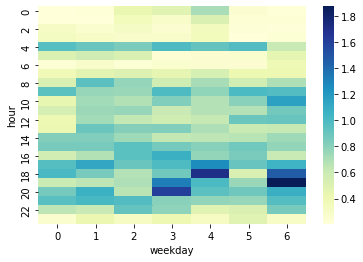

In [14]:
# consumption by hour and weekday in summer 
heatmap4_data = pd.pivot_table(summer, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap4_data, cmap="YlGnBu")

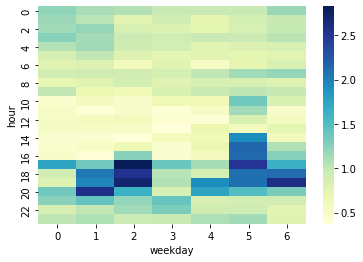

In [15]:
# consumption by hour and weekday in autumn
heatmap5_data = pd.pivot_table(autumn, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap5_data, cmap="YlGnBu")

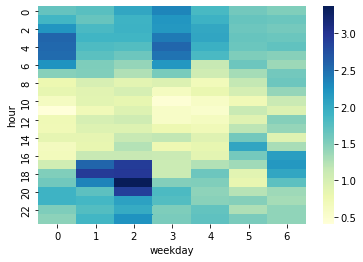

In [16]:
# consumption by hour and weekday in winter 
heatmap6_data = pd.pivot_table(winter, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap6_data, cmap="YlGnBu")

In [21]:
# consumption by hour and weekday in workdays

holidays = df[df['is_holiday'] == True]

holidays


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,timestamp,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
2737,2021-12-24 00:00:00+02:00,-3.7,-5.5,87.0,0.0,0.0,200.0,14.4,33.3,995.0,14.0,0.09885,1.412,2021-12-24 00:00:00,2021-12-24 00:00:00,2021,12,24,4,0,2021-12-24,True,Winter,53
2738,2021-12-24 01:00:00+02:00,-3.1,-4.7,89.0,0.0,0.0,200.0,14.4,33.3,994.2,14.0,0.10742,1.083,2021-12-24 01:00:00,2021-12-24 01:00:00,2021,12,24,4,1,2021-12-24,True,Winter,53
2739,2021-12-24 02:00:00+02:00,-2.5,-4.1,89.0,0.0,0.0,190.0,10.8,31.5,992.9,14.0,0.09614,1.467,2021-12-24 02:00:00,2021-12-24 02:00:00,2021,12,24,4,2,2021-12-24,True,Winter,53
2740,2021-12-24 03:00:00+02:00,-2.3,-3.6,91.0,0.0,0.0,200.0,10.8,33.3,991.8,14.0,0.08929,1.427,2021-12-24 03:00:00,2021-12-24 03:00:00,2021,12,24,4,3,2021-12-24,True,Winter,53
2741,2021-12-24 04:00:00+02:00,-1.6,-2.4,94.0,0.0,0.0,200.0,14.4,31.5,991.0,14.0,0.08178,1.087,2021-12-24 04:00:00,2021-12-24 04:00:00,2021,12,24,4,4,2021-12-24,True,Winter,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8491,2022-08-20 19:00:00+03:00,24.1,13.0,50.0,0.0,0.0,130.0,11.0,31.5,1018.0,2.0,0.07822,0.742,2022-08-20 19:00:00,2022-08-20 19:00:00,2022,8,20,5,19,2022-08-20,True,Summer,100
8492,2022-08-20 20:00:00+03:00,22.1,13.2,57.0,0.0,0.0,120.0,9.0,27.8,1018.0,2.0,0.07909,0.528,2022-08-20 20:00:00,2022-08-20 20:00:00,2022,8,20,5,20,2022-08-20,True,Summer,100
8493,2022-08-20 21:00:00+03:00,22.2,13.8,59.0,0.0,0.0,110.0,7.0,24.1,1017.9,1.0,0.06225,1.103,2022-08-20 21:00:00,2022-08-20 21:00:00,2022,8,20,5,21,2022-08-20,True,Summer,100
8494,2022-08-20 22:00:00+03:00,19.1,13.1,68.0,0.0,0.0,90.0,4.0,20.4,1017.0,1.0,0.53533,0.335,2022-08-20 22:00:00,2022-08-20 22:00:00,2022,8,20,5,22,2022-08-20,True,Summer,100


In [ ]:
# consumption by hour and weekday in weekends and holidays

heatmap6_data = pd.pivot_table(winter, values='consumption', 
                     index=['hour'], 
                     columns='weekday')

sns.heatmap(heatmap6_data, cmap="YlGnBu")

In [17]:
# ORIGINAL DATASET

# TIME
# time - definition of example_id

# WEATHER
# temp - Air Temperature (°C)
# dwpt - The dew point in °C
# rhum - The relative humidity in percent (%)
# prcp - The one hour precipitation total in mm
# snow - The snow depth in mm
# wdir - The wind direction in degrees (°)
# wspd - The average wind speed in km/h
# wpgt - The peak wind gust in km/h
# pres - The sea-level air pressure in hPa
# coco - The weather condition code

# ELECTRICITY PRICE
# el_price - the electricity price in Estonia on that hour (€/kWh)

# CONSUMPTION
# consumption - the electricity consumption (kWh)


# AUGMENTED DATASET

# ID
# time - definition of example_id
 
# WEATHER
# temp - Air Temperature (°C)
# dwpt - The dew point in °C
# rhum - The relative humidity in percent (%)
# prcp - The one hour precipitation total in mm
# snow - The snow depth in mm
# wdir - The wind direction in degrees (°)
# wspd - The average wind speed in km/h
# wpgt - The peak wind gust in km/h
# pres - The sea-level air pressure in hPa
# coco - The weather condition code

# ELECTRICITY PRICE
# el_price - the electricity price in Estonia on that hour (€/kWh)

# CONSUMPTION
# consumption - the electricity consumption (kWh)

# TIME
# timestamp
# datetime
# year
# month
# day
# weekday
# hour
# date
# is_holiday
# season

# ADDITIONAL
# google_trends_electricity

In [18]:
pd.set_option('display.max_columns', None)
df.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,timestamp,datetime,year,month,day,weekday,hour,date,is_holiday,season,google_trends_electricity
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,0.0,0.0,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577,2021-09-01 00:00:00,2021-09-01 00:00:00,2021,9,1,2,0,2021-09-01,False,Autumn,5
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,0.0,0.0,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594,2021-09-01 01:00:00,2021-09-01 01:00:00,2021,9,1,2,1,2021-09-01,False,Autumn,5
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,0.0,0.0,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685,2021-09-01 02:00:00,2021-09-01 02:00:00,2021,9,1,2,2,2021-09-01,False,Autumn,5
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,0.0,0.0,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016,2021-09-01 03:00:00,2021-09-01 03:00:00,2021,9,1,2,3,2021-09-01,False,Autumn,5
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,0.0,0.0,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677,2021-09-01 04:00:00,2021-09-01 04:00:00,2021,9,1,2,4,2021-09-01,False,Autumn,5
